### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 0  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:08<95:01:37, 68.43s/it]

Entrenando:   0%|          | 2/5000 [02:15<94:05:57, 67.78s/it]

Entrenando:   0%|          | 3/5000 [03:23<93:49:50, 67.60s/it]

Entrenando:   0%|          | 4/5000 [04:30<93:52:26, 67.64s/it]

Entrenando:   0%|          | 5/5000 [05:38<93:39:36, 67.50s/it]

Entrenando:   0%|          | 6/5000 [06:46<93:53:49, 67.69s/it]

Entrenando:   0%|          | 7/5000 [07:53<93:50:44, 67.66s/it]

Entrenando:   0%|          | 8/5000 [09:01<93:43:02, 67.58s/it]

Entrenando:   0%|          | 9/5000 [10:09<93:55:50, 67.75s/it]

Entrenando:   0%|          | 10/5000 [11:16<93:51:05, 67.71s/it]

Entrenando:   0%|          | 11/5000 [12:24<93:58:03, 67.81s/it]

Entrenando:   0%|          | 12/5000 [13:33<94:06:27, 67.92s/it]

Entrenando:   0%|          | 13/5000 [14:41<94:25:50, 68.17s/it]

Entrenando:   0%|          | 14/5000 [15:49<94:20:16, 68.11s/it]

Entrenando:   0%|          | 15/5000 [16:57<94:03:21, 67.92s/it]

Entrenando:   0%|          | 16/5000 [18:05<94:01:49, 67.92s/it]

Entrenando:   0%|          | 17/5000 [19:12<93:56:35, 67.87s/it]

Entrenando:   0%|          | 18/5000 [20:21<94:13:37, 68.09s/it]

Entrenando:   0%|          | 19/5000 [21:29<94:09:32, 68.05s/it]

Entrenando:   0%|          | 20/5000 [22:38<94:29:05, 68.30s/it]

Entrenando:   0%|          | 21/5000 [24:05<102:12:05, 73.90s/it]

Entrenando:   0%|          | 22/5000 [25:51<115:43:26, 83.69s/it]

Entrenando:   0%|          | 23/5000 [27:34<123:38:18, 89.43s/it]

Entrenando:   0%|          | 24/5000 [29:22<131:19:05, 95.01s/it]

Entrenando:   0%|          | 25/5000 [31:02<133:18:44, 96.47s/it]

Entrenando:   1%|          | 26/5000 [32:54<139:45:49, 101.16s/it]

Entrenando:   1%|          | 27/5000 [34:45<143:38:23, 103.98s/it]

Entrenando:   1%|          | 28/5000 [36:26<142:31:45, 103.20s/it]

Entrenando:   1%|          | 29/5000 [38:29<150:41:46, 109.13s/it]

Entrenando:   1%|          | 30/5000 [41:20<176:17:29, 127.70s/it]

Entrenando:   1%|          | 31/5000 [44:19<197:27:47, 143.06s/it]

Entrenando:   1%|          | 32/5000 [47:04<206:38:47, 149.74s/it]

Entrenando:   1%|          | 33/5000 [49:51<213:23:09, 154.66s/it]

Entrenando:   1%|          | 34/5000 [52:47<222:33:45, 161.34s/it]

Entrenando:   1%|          | 35/5000 [55:46<229:47:05, 166.61s/it]

Entrenando:   1%|          | 36/5000 [58:37<231:34:11, 167.94s/it]

Entrenando:   1%|          | 37/5000 [1:01:50<241:39:52, 175.30s/it]

Entrenando:   1%|          | 38/5000 [1:05:38<263:22:55, 191.09s/it]

Entrenando:   1%|          | 39/5000 [1:09:36<283:00:11, 205.36s/it]

Entrenando:   1%|          | 40/5000 [1:13:29<294:07:36, 213.48s/it]

Entrenando:   1%|          | 41/5000 [1:17:25<303:19:01, 220.19s/it]

Entrenando:   1%|          | 42/5000 [1:21:15<307:26:40, 223.24s/it]

Entrenando:   1%|          | 43/5000 [1:25:06<310:34:41, 225.56s/it]

Entrenando:   1%|          | 44/5000 [1:28:54<311:39:43, 226.39s/it]

Entrenando:   1%|          | 45/5000 [1:32:43<312:23:48, 226.97s/it]

Entrenando:   1%|          | 46/5000 [1:36:28<311:37:44, 226.46s/it]

Entrenando:   1%|          | 47/5000 [1:40:10<309:55:44, 225.27s/it]

Entrenando:   1%|          | 48/5000 [1:43:56<310:04:43, 225.42s/it]

Entrenando:   1%|          | 49/5000 [1:47:39<309:02:23, 224.71s/it]

Entrenando:   1%|          | 50/5000 [1:51:11<303:35:19, 220.79s/it]

Iter  50: train_loss=0.2611, val_loss=0.2735, train_suc=0.751, train_err=0.242, train_inc=0.006 | val_suc=0.740, val_err=0.253, val_inc=0.007


Entrenando:   1%|          | 51/5000 [1:54:42<299:30:26, 217.87s/it]

Entrenando:   1%|          | 52/5000 [1:58:01<291:38:19, 212.19s/it]

Entrenando:   1%|          | 53/5000 [2:01:03<279:12:07, 203.18s/it]

Entrenando:   1%|          | 54/5000 [2:04:01<268:49:54, 195.67s/it]

Entrenando:   1%|          | 55/5000 [2:07:14<267:37:09, 194.83s/it]

Entrenando:   1%|          | 56/5000 [2:10:10<259:51:15, 189.21s/it]

Entrenando:   1%|          | 57/5000 [2:12:56<250:21:10, 182.33s/it]

Entrenando:   1%|          | 58/5000 [2:15:48<245:54:09, 179.13s/it]

Entrenando:   1%|          | 59/5000 [2:18:38<241:57:24, 176.29s/it]

Entrenando:   1%|          | 60/5000 [2:21:29<239:40:19, 174.66s/it]

Entrenando:   1%|          | 61/5000 [2:24:09<233:31:29, 170.21s/it]

Entrenando:   1%|          | 62/5000 [2:26:51<230:13:32, 167.84s/it]

Entrenando:   1%|▏         | 63/5000 [2:29:24<224:01:19, 163.35s/it]

Entrenando:   1%|▏         | 64/5000 [2:32:20<229:06:23, 167.10s/it]

Entrenando:   1%|▏         | 65/5000 [2:34:58<225:32:12, 164.53s/it]

Entrenando:   1%|▏         | 66/5000 [2:37:40<224:18:16, 163.66s/it]

Entrenando:   1%|▏         | 67/5000 [2:40:11<219:06:26, 159.90s/it]

Entrenando:   1%|▏         | 68/5000 [2:42:39<214:27:07, 156.53s/it]

Entrenando:   1%|▏         | 69/5000 [2:44:58<206:57:59, 151.10s/it]

Entrenando:   1%|▏         | 70/5000 [2:47:17<201:48:16, 147.36s/it]

Entrenando:   1%|▏         | 71/5000 [2:49:37<198:50:31, 145.23s/it]

Entrenando:   1%|▏         | 72/5000 [2:51:50<193:41:41, 141.50s/it]

Entrenando:   1%|▏         | 73/5000 [2:53:57<187:51:56, 137.27s/it]

Entrenando:   1%|▏         | 74/5000 [2:56:01<182:34:46, 133.43s/it]

Entrenando:   2%|▏         | 75/5000 [2:58:03<177:44:59, 129.93s/it]

Entrenando:   2%|▏         | 76/5000 [3:00:02<173:01:36, 126.50s/it]

Entrenando:   2%|▏         | 77/5000 [3:02:03<170:42:15, 124.83s/it]

Entrenando:   2%|▏         | 78/5000 [3:04:04<169:16:43, 123.81s/it]

Entrenando:   2%|▏         | 79/5000 [3:06:15<172:04:39, 125.88s/it]

Entrenando:   2%|▏         | 80/5000 [3:08:10<167:39:00, 122.67s/it]

Entrenando:   2%|▏         | 81/5000 [3:09:56<160:37:40, 117.56s/it]

Entrenando:   2%|▏         | 82/5000 [3:11:56<161:48:11, 118.44s/it]

Entrenando:   2%|▏         | 83/5000 [3:13:56<162:13:09, 118.77s/it]

Entrenando:   2%|▏         | 84/5000 [3:15:52<161:16:16, 118.10s/it]

Entrenando:   2%|▏         | 85/5000 [3:17:45<159:15:43, 116.65s/it]

Entrenando:   2%|▏         | 86/5000 [3:19:49<161:58:47, 118.67s/it]

Entrenando:   2%|▏         | 87/5000 [3:21:41<159:13:04, 116.67s/it]

Entrenando:   2%|▏         | 88/5000 [3:23:44<161:39:20, 118.48s/it]

Entrenando:   2%|▏         | 89/5000 [3:25:36<158:59:41, 116.55s/it]

Entrenando:   2%|▏         | 90/5000 [3:27:42<162:56:44, 119.47s/it]

Entrenando:   2%|▏         | 91/5000 [3:29:40<162:12:53, 118.96s/it]

Entrenando:   2%|▏         | 92/5000 [3:31:40<162:43:41, 119.36s/it]

Entrenando:   2%|▏         | 93/5000 [3:33:34<160:27:32, 117.72s/it]

Entrenando:   2%|▏         | 94/5000 [3:35:30<159:52:27, 117.32s/it]

Entrenando:   2%|▏         | 95/5000 [3:37:23<157:58:44, 115.95s/it]

Entrenando:   2%|▏         | 96/5000 [3:39:13<155:22:37, 114.06s/it]

Entrenando:   2%|▏         | 97/5000 [3:41:08<156:04:43, 114.60s/it]

Entrenando:   2%|▏         | 98/5000 [3:43:18<162:19:26, 119.21s/it]

Entrenando:   2%|▏         | 99/5000 [3:45:10<159:06:27, 116.87s/it]

Entrenando:   2%|▏         | 100/5000 [3:47:05<158:16:08, 116.28s/it]

Iter 100: train_loss=0.1654, val_loss=0.2295, train_suc=0.783, train_err=0.217, train_inc=0.000 | val_suc=0.771, val_err=0.229, val_inc=0.000
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [3:49:04<159:19:04, 117.07s/it]

Entrenando:   2%|▏         | 102/5000 [3:51:01<159:27:52, 117.21s/it]

Entrenando:   2%|▏         | 103/5000 [3:52:54<157:26:25, 115.74s/it]

Entrenando:   2%|▏         | 104/5000 [3:54:48<156:47:25, 115.29s/it]

Entrenando:   2%|▏         | 105/5000 [3:56:40<155:31:20, 114.38s/it]

Entrenando:   2%|▏         | 106/5000 [3:58:34<155:18:18, 114.24s/it]

Entrenando:   2%|▏         | 107/5000 [4:00:31<156:13:22, 114.94s/it]

Entrenando:   2%|▏         | 108/5000 [4:02:21<154:18:43, 113.56s/it]

Entrenando:   2%|▏         | 109/5000 [4:04:14<154:14:05, 113.52s/it]

Entrenando:   2%|▏         | 110/5000 [4:06:09<154:34:25, 113.80s/it]

Entrenando:   2%|▏         | 111/5000 [4:08:04<155:07:21, 114.22s/it]

Entrenando:   2%|▏         | 112/5000 [4:09:57<154:48:06, 114.01s/it]

Entrenando:   2%|▏         | 113/5000 [4:11:50<154:16:41, 113.65s/it]

Entrenando:   2%|▏         | 114/5000 [4:13:50<156:36:46, 115.39s/it]

Entrenando:   2%|▏         | 115/5000 [4:15:46<156:49:35, 115.57s/it]

Entrenando:   2%|▏         | 116/5000 [4:17:37<155:00:25, 114.26s/it]

Entrenando:   2%|▏         | 117/5000 [4:19:32<155:22:47, 114.55s/it]

Entrenando:   2%|▏         | 118/5000 [4:21:24<154:24:10, 113.86s/it]

Entrenando:   2%|▏         | 119/5000 [4:23:22<155:47:41, 114.91s/it]

Entrenando:   2%|▏         | 120/5000 [4:25:27<159:56:22, 117.99s/it]

Entrenando:   2%|▏         | 121/5000 [4:27:18<157:17:05, 116.05s/it]

Entrenando:   2%|▏         | 122/5000 [4:29:18<158:36:28, 117.05s/it]

Entrenando:   2%|▏         | 123/5000 [4:31:11<156:59:05, 115.88s/it]

Entrenando:   2%|▏         | 124/5000 [4:33:13<159:28:55, 117.75s/it]

Entrenando:   2%|▎         | 125/5000 [4:35:06<157:35:20, 116.37s/it]

Entrenando:   3%|▎         | 126/5000 [4:36:52<153:24:35, 113.31s/it]

Entrenando:   3%|▎         | 127/5000 [4:38:55<156:56:40, 115.95s/it]

Entrenando:   3%|▎         | 128/5000 [4:40:41<153:14:19, 113.23s/it]

Entrenando:   3%|▎         | 129/5000 [4:42:32<151:57:51, 112.31s/it]

Entrenando:   3%|▎         | 130/5000 [4:44:20<150:12:22, 111.04s/it]

Entrenando:   3%|▎         | 131/5000 [4:46:18<153:11:33, 113.27s/it]

Entrenando:   3%|▎         | 132/5000 [4:48:16<155:13:26, 114.79s/it]

Entrenando:   3%|▎         | 133/5000 [4:50:14<156:22:52, 115.67s/it]

Entrenando:   3%|▎         | 134/5000 [4:52:07<155:15:07, 114.86s/it]

Entrenando:   3%|▎         | 135/5000 [4:54:05<156:18:21, 115.66s/it]

Entrenando:   3%|▎         | 136/5000 [4:56:04<157:43:33, 116.74s/it]

Entrenando:   3%|▎         | 137/5000 [4:57:54<155:03:45, 114.79s/it]

Entrenando:   3%|▎         | 138/5000 [4:59:50<155:18:14, 114.99s/it]

Entrenando:   3%|▎         | 139/5000 [5:01:45<155:30:33, 115.17s/it]

Entrenando:   3%|▎         | 140/5000 [5:03:45<157:20:43, 116.55s/it]

Entrenando:   3%|▎         | 141/5000 [5:05:42<157:34:03, 116.74s/it]

Entrenando:   3%|▎         | 142/5000 [5:07:41<158:29:55, 117.45s/it]

Entrenando:   3%|▎         | 143/5000 [5:09:37<157:43:25, 116.90s/it]

Entrenando:   3%|▎         | 144/5000 [5:11:29<155:50:08, 115.53s/it]

Entrenando:   3%|▎         | 145/5000 [5:13:31<158:25:57, 117.48s/it]

Entrenando:   3%|▎         | 146/5000 [5:15:28<158:17:17, 117.40s/it]

Entrenando:   3%|▎         | 147/5000 [5:17:34<161:22:49, 119.71s/it]

Entrenando:   3%|▎         | 148/5000 [5:20:34<185:43:34, 137.80s/it]

Entrenando:   3%|▎         | 149/5000 [5:23:51<209:51:30, 155.74s/it]

Entrenando:   3%|▎         | 150/5000 [5:27:13<228:37:19, 169.70s/it]

Iter 150: train_loss=0.2403, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   3%|▎         | 151/5000 [5:30:34<241:04:26, 178.98s/it]

Entrenando:   3%|▎         | 152/5000 [5:33:54<249:29:53, 185.27s/it]

Entrenando:   3%|▎         | 153/5000 [5:37:19<257:28:43, 191.24s/it]

Entrenando:   3%|▎         | 154/5000 [5:40:37<259:59:23, 193.14s/it]

Entrenando:   3%|▎         | 155/5000 [5:44:08<267:19:00, 198.63s/it]

Entrenando:   3%|▎         | 156/5000 [5:47:41<272:49:17, 202.76s/it]

Entrenando:   3%|▎         | 157/5000 [5:51:16<277:50:40, 206.53s/it]

Entrenando:   3%|▎         | 158/5000 [5:54:54<282:24:28, 209.97s/it]

Entrenando:   3%|▎         | 159/5000 [5:58:26<283:17:40, 210.67s/it]

Entrenando:   3%|▎         | 160/5000 [6:02:00<284:22:02, 211.51s/it]

Entrenando:   3%|▎         | 161/5000 [6:05:32<284:27:37, 211.63s/it]

Entrenando:   3%|▎         | 162/5000 [6:09:01<283:36:08, 211.03s/it]

Entrenando:   3%|▎         | 163/5000 [6:12:35<284:37:25, 211.83s/it]

Entrenando:   3%|▎         | 164/5000 [6:16:09<285:16:58, 212.37s/it]

Entrenando:   3%|▎         | 165/5000 [6:19:45<286:48:55, 213.55s/it]

Entrenando:   3%|▎         | 166/5000 [6:23:21<287:50:01, 214.36s/it]

Entrenando:   3%|▎         | 167/5000 [6:26:53<286:40:56, 213.54s/it]

Entrenando:   3%|▎         | 168/5000 [6:30:23<285:27:35, 212.68s/it]

Entrenando:   3%|▎         | 169/5000 [6:33:45<280:51:19, 209.29s/it]

Entrenando:   3%|▎         | 170/5000 [6:36:56<273:39:55, 203.97s/it]

Entrenando:   3%|▎         | 171/5000 [6:40:11<269:42:34, 201.07s/it]

Entrenando:   3%|▎         | 172/5000 [6:43:11<261:16:09, 194.82s/it]

Entrenando:   3%|▎         | 173/5000 [6:46:07<253:31:46, 189.08s/it]

Entrenando:   3%|▎         | 174/5000 [6:48:54<244:34:31, 182.44s/it]

Entrenando:   4%|▎         | 175/5000 [6:51:44<239:41:52, 178.84s/it]

Entrenando:   4%|▎         | 176/5000 [6:54:31<234:44:53, 175.19s/it]

Entrenando:   4%|▎         | 177/5000 [6:57:11<228:46:56, 170.77s/it]

Entrenando:   4%|▎         | 178/5000 [6:59:47<222:35:33, 166.18s/it]

Entrenando:   4%|▎         | 179/5000 [7:02:16<215:45:08, 161.11s/it]

Entrenando:   4%|▎         | 180/5000 [7:04:42<209:38:44, 156.58s/it]

Entrenando:   4%|▎         | 181/5000 [7:07:04<203:44:34, 152.20s/it]

Entrenando:   4%|▎         | 182/5000 [7:09:25<199:11:16, 148.83s/it]

Entrenando:   4%|▎         | 183/5000 [7:11:44<195:16:26, 145.94s/it]

Entrenando:   4%|▎         | 184/5000 [7:14:07<194:03:17, 145.06s/it]

Entrenando:   4%|▎         | 185/5000 [7:16:24<190:37:04, 142.52s/it]

Entrenando:   4%|▎         | 186/5000 [7:18:42<189:02:07, 141.36s/it]

Entrenando:   4%|▎         | 187/5000 [7:20:52<184:27:20, 137.97s/it]

Entrenando:   4%|▍         | 188/5000 [7:23:02<181:01:26, 135.43s/it]

Entrenando:   4%|▍         | 189/5000 [7:25:11<178:35:44, 133.64s/it]

Entrenando:   4%|▍         | 190/5000 [7:27:15<174:25:13, 130.54s/it]

Entrenando:   4%|▍         | 191/5000 [7:29:21<172:44:10, 129.31s/it]

Entrenando:   4%|▍         | 192/5000 [7:31:19<168:00:25, 125.80s/it]

Entrenando:   4%|▍         | 193/5000 [7:33:18<165:25:03, 123.88s/it]

Entrenando:   4%|▍         | 194/5000 [7:35:19<164:10:30, 122.98s/it]

Entrenando:   4%|▍         | 195/5000 [7:37:16<161:58:13, 121.35s/it]

Entrenando:   4%|▍         | 196/5000 [7:39:12<159:26:39, 119.48s/it]

Entrenando:   4%|▍         | 197/5000 [7:41:05<157:00:32, 117.68s/it]

Entrenando:   4%|▍         | 198/5000 [7:43:00<155:58:00, 116.93s/it]

Entrenando:   4%|▍         | 199/5000 [7:45:01<157:33:29, 118.14s/it]

Entrenando:   4%|▍         | 200/5000 [7:46:53<155:02:35, 116.28s/it]

Iter 200: train_loss=0.2221, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [7:48:45<153:14:04, 114.95s/it]

Entrenando:   4%|▍         | 202/5000 [7:50:44<154:42:44, 116.08s/it]

Entrenando:   4%|▍         | 203/5000 [7:52:34<152:20:27, 114.33s/it]

Entrenando:   4%|▍         | 204/5000 [7:54:40<156:55:22, 117.79s/it]

Entrenando:   4%|▍         | 205/5000 [7:56:39<157:21:07, 118.14s/it]

Entrenando:   4%|▍         | 206/5000 [7:58:38<157:52:30, 118.55s/it]

Entrenando:   4%|▍         | 207/5000 [8:00:35<157:06:02, 118.00s/it]

Entrenando:   4%|▍         | 208/5000 [8:02:40<159:43:27, 119.99s/it]

Entrenando:   4%|▍         | 209/5000 [8:04:35<158:01:13, 118.74s/it]

Entrenando:   4%|▍         | 210/5000 [8:06:33<157:37:00, 118.46s/it]

Entrenando:   4%|▍         | 211/5000 [8:08:37<159:44:56, 120.09s/it]

Entrenando:   4%|▍         | 212/5000 [8:10:36<159:23:56, 119.85s/it]

Entrenando:   4%|▍         | 213/5000 [8:12:38<159:56:58, 120.29s/it]

Entrenando:   4%|▍         | 214/5000 [8:14:32<157:31:38, 118.49s/it]

Entrenando:   4%|▍         | 215/5000 [8:16:29<157:01:48, 118.14s/it]

Entrenando:   4%|▍         | 216/5000 [8:18:18<153:07:32, 115.23s/it]

Entrenando:   4%|▍         | 217/5000 [8:20:11<152:09:26, 114.52s/it]

Entrenando:   4%|▍         | 218/5000 [8:22:10<153:53:26, 115.85s/it]

Entrenando:   4%|▍         | 219/5000 [8:23:59<151:16:39, 113.91s/it]

Entrenando:   4%|▍         | 220/5000 [8:25:50<149:52:55, 112.88s/it]

Entrenando:   4%|▍         | 221/5000 [8:27:56<155:24:59, 117.07s/it]

Entrenando:   4%|▍         | 222/5000 [8:30:01<158:13:29, 119.21s/it]

Entrenando:   4%|▍         | 223/5000 [8:31:49<154:03:40, 116.10s/it]

Entrenando:   4%|▍         | 224/5000 [8:33:51<156:17:14, 117.80s/it]

Entrenando:   4%|▍         | 225/5000 [8:35:55<158:44:02, 119.67s/it]

Entrenando:   5%|▍         | 226/5000 [8:37:49<156:27:25, 117.98s/it]

Entrenando:   5%|▍         | 227/5000 [8:39:50<157:35:11, 118.86s/it]

Entrenando:   5%|▍         | 228/5000 [8:41:44<155:21:33, 117.20s/it]

Entrenando:   5%|▍         | 229/5000 [8:43:48<158:14:03, 119.40s/it]

Entrenando:   5%|▍         | 230/5000 [8:45:42<156:06:22, 117.82s/it]

Entrenando:   5%|▍         | 231/5000 [8:47:44<157:35:46, 118.97s/it]

Entrenando:   5%|▍         | 232/5000 [8:50:52<184:58:13, 139.66s/it]

Entrenando:   5%|▍         | 233/5000 [8:53:37<195:04:46, 147.32s/it]

Entrenando:   5%|▍         | 234/5000 [8:56:42<210:05:54, 158.70s/it]

Entrenando:   5%|▍         | 235/5000 [8:59:44<219:15:48, 165.66s/it]

Entrenando:   5%|▍         | 236/5000 [9:02:28<218:23:45, 165.03s/it]

Entrenando:   5%|▍         | 237/5000 [9:05:23<222:21:09, 168.06s/it]

Entrenando:   5%|▍         | 238/5000 [9:08:34<231:37:11, 175.10s/it]

Entrenando:   5%|▍         | 239/5000 [9:11:34<233:16:57, 176.40s/it]

Entrenando:   5%|▍         | 240/5000 [9:14:36<235:21:54, 178.01s/it]

Entrenando:   5%|▍         | 241/5000 [9:17:40<237:58:25, 180.02s/it]

Entrenando:   5%|▍         | 242/5000 [9:20:38<237:10:46, 179.45s/it]

Entrenando:   5%|▍         | 243/5000 [9:23:24<231:33:18, 175.24s/it]

Entrenando:   5%|▍         | 244/5000 [9:26:12<228:38:49, 173.07s/it]

Entrenando:   5%|▍         | 245/5000 [9:29:11<231:08:43, 175.00s/it]

Entrenando:   5%|▍         | 246/5000 [9:32:20<236:28:10, 179.07s/it]

Entrenando:   5%|▍         | 247/5000 [9:35:17<235:32:31, 178.40s/it]

Entrenando:   5%|▍         | 248/5000 [9:38:05<231:20:59, 175.26s/it]

Entrenando:   5%|▍         | 249/5000 [9:41:01<231:36:19, 175.50s/it]

Entrenando:   5%|▌         | 250/5000 [9:43:52<229:54:32, 174.25s/it]

Iter 250: train_loss=0.2161, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   5%|▌         | 251/5000 [9:46:45<229:33:12, 174.01s/it]

Entrenando:   5%|▌         | 252/5000 [9:49:36<228:02:42, 172.91s/it]

Entrenando:   5%|▌         | 253/5000 [9:52:36<230:49:51, 175.06s/it]

Entrenando:   5%|▌         | 254/5000 [9:55:36<232:45:03, 176.55s/it]

Entrenando:   5%|▌         | 255/5000 [9:58:41<236:01:48, 179.07s/it]

Entrenando:   5%|▌         | 256/5000 [10:01:40<236:07:26, 179.18s/it]

Entrenando:   5%|▌         | 257/5000 [10:04:38<235:39:36, 178.87s/it]

Entrenando:   5%|▌         | 258/5000 [10:07:34<234:18:26, 177.88s/it]

Entrenando:   5%|▌         | 259/5000 [10:10:43<238:42:26, 181.26s/it]

Entrenando:   5%|▌         | 260/5000 [10:13:46<239:10:20, 181.65s/it]

Entrenando:   5%|▌         | 261/5000 [10:16:37<234:51:24, 178.41s/it]

Entrenando:   5%|▌         | 262/5000 [10:19:32<233:47:53, 177.64s/it]

Entrenando:   5%|▌         | 263/5000 [10:22:23<230:46:08, 175.38s/it]

Entrenando:   5%|▌         | 264/5000 [10:25:25<233:34:58, 177.55s/it]

Entrenando:   5%|▌         | 265/5000 [10:28:26<234:43:43, 178.46s/it]

Entrenando:   5%|▌         | 266/5000 [10:31:08<228:12:53, 173.55s/it]

Entrenando:   5%|▌         | 267/5000 [10:34:13<232:49:54, 177.10s/it]

Entrenando:   5%|▌         | 268/5000 [10:37:12<233:35:12, 177.71s/it]

Entrenando:   5%|▌         | 269/5000 [10:40:09<232:57:21, 177.27s/it]

Entrenando:   5%|▌         | 270/5000 [10:42:53<227:46:05, 173.35s/it]

Entrenando:   5%|▌         | 271/5000 [10:45:36<223:34:46, 170.20s/it]

Entrenando:   5%|▌         | 272/5000 [10:48:17<220:11:21, 167.66s/it]

Entrenando:   5%|▌         | 273/5000 [10:51:00<218:03:55, 166.07s/it]

Entrenando:   5%|▌         | 274/5000 [10:53:42<216:21:18, 164.81s/it]

Entrenando:   6%|▌         | 275/5000 [10:56:31<218:04:18, 166.15s/it]

Entrenando:   6%|▌         | 276/5000 [10:59:41<227:33:37, 173.42s/it]

Entrenando:   6%|▌         | 277/5000 [11:02:42<230:14:41, 175.50s/it]

Entrenando:   6%|▌         | 278/5000 [11:05:28<226:42:38, 172.84s/it]

Entrenando:   6%|▌         | 279/5000 [11:08:19<225:46:36, 172.17s/it]

Entrenando:   6%|▌         | 280/5000 [11:11:15<227:09:28, 173.26s/it]

Entrenando:   6%|▌         | 281/5000 [11:14:09<227:31:50, 173.58s/it]

Entrenando:   6%|▌         | 282/5000 [11:17:12<231:15:41, 176.46s/it]

Entrenando:   6%|▌         | 283/5000 [11:20:03<228:57:50, 174.74s/it]

Entrenando:   6%|▌         | 284/5000 [11:22:55<227:43:35, 173.84s/it]

Entrenando:   6%|▌         | 285/5000 [11:25:57<231:07:23, 176.47s/it]

Entrenando:   6%|▌         | 286/5000 [11:28:52<230:13:36, 175.82s/it]

Entrenando:   6%|▌         | 287/5000 [11:31:48<230:29:46, 176.06s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:   6%|▌         | 288/5000 [11:34:38<228:04:33, 174.25s/it]

Entrenando:   6%|▌         | 289/5000 [11:37:45<233:06:58, 178.14s/it]

Entrenando:   6%|▌         | 290/5000 [11:40:35<229:54:51, 175.73s/it]

Entrenando:   6%|▌         | 291/5000 [11:43:35<231:11:10, 176.74s/it]

Entrenando:   6%|▌         | 292/5000 [11:46:31<230:51:40, 176.53s/it]

Entrenando:   6%|▌         | 293/5000 [11:49:15<225:53:14, 172.76s/it]

Entrenando:   6%|▌         | 294/5000 [11:52:19<230:14:12, 176.13s/it]

Entrenando:   6%|▌         | 295/5000 [11:55:33<237:27:39, 181.69s/it]

Entrenando:   6%|▌         | 296/5000 [11:58:20<231:41:50, 177.32s/it]

Entrenando:   6%|▌         | 297/5000 [12:01:21<233:05:07, 178.42s/it]

Entrenando:   6%|▌         | 298/5000 [12:04:27<235:52:45, 180.60s/it]

Entrenando:   6%|▌         | 299/5000 [12:07:39<240:16:32, 184.00s/it]

Entrenando:   6%|▌         | 300/5000 [12:10:40<239:08:27, 183.17s/it]

Iter 300: train_loss=0.2184, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 300: LR actual = 0.005000


Entrenando:   6%|▌         | 301/5000 [12:13:33<234:54:51, 179.97s/it]

Entrenando:   6%|▌         | 302/5000 [12:16:31<234:20:06, 179.57s/it]

Entrenando:   6%|▌         | 303/5000 [12:19:19<229:35:08, 175.97s/it]

Entrenando:   6%|▌         | 304/5000 [12:22:11<227:59:30, 174.78s/it]

Entrenando:   6%|▌         | 305/5000 [12:25:07<228:33:28, 175.25s/it]

Entrenando:   6%|▌         | 306/5000 [12:28:05<229:29:17, 176.00s/it]

Entrenando:   6%|▌         | 307/5000 [12:31:03<230:18:54, 176.67s/it]

Entrenando:   6%|▌         | 308/5000 [12:34:13<235:26:04, 180.64s/it]

Entrenando:   6%|▌         | 309/5000 [12:37:15<236:00:23, 181.12s/it]

Entrenando:   6%|▌         | 310/5000 [12:40:10<233:16:45, 179.06s/it]

Entrenando:   6%|▌         | 311/5000 [12:42:48<225:18:57, 172.99s/it]

Entrenando:   6%|▌         | 312/5000 [12:45:35<222:40:23, 170.99s/it]

Entrenando:   6%|▋         | 313/5000 [12:48:38<227:34:24, 174.80s/it]

Entrenando:   6%|▋         | 314/5000 [12:51:31<226:31:36, 174.03s/it]

Entrenando:   6%|▋         | 315/5000 [12:54:24<226:12:30, 173.82s/it]

Entrenando:   6%|▋         | 316/5000 [12:57:18<226:13:41, 173.87s/it]

Entrenando:   6%|▋         | 317/5000 [13:00:27<232:11:56, 178.50s/it]

Entrenando:   6%|▋         | 318/5000 [13:03:17<228:44:08, 175.88s/it]

Entrenando:   6%|▋         | 319/5000 [13:06:21<231:45:53, 178.24s/it]

Entrenando:   6%|▋         | 320/5000 [13:09:20<231:56:07, 178.41s/it]

Entrenando:   6%|▋         | 321/5000 [13:12:08<228:05:52, 175.50s/it]

Entrenando:   6%|▋         | 322/5000 [13:15:01<226:56:48, 174.65s/it]

Entrenando:   6%|▋         | 323/5000 [13:17:55<226:40:11, 174.47s/it]

Entrenando:   6%|▋         | 324/5000 [13:21:08<233:43:55, 179.95s/it]

Entrenando:   6%|▋         | 325/5000 [13:24:05<232:30:38, 179.05s/it]

Entrenando:   7%|▋         | 326/5000 [13:27:22<239:22:12, 184.37s/it]

Entrenando:   7%|▋         | 327/5000 [13:30:05<231:09:00, 178.07s/it]

Entrenando:   7%|▋         | 328/5000 [13:33:03<231:13:46, 178.17s/it]

Entrenando:   7%|▋         | 329/5000 [13:36:05<232:30:19, 179.19s/it]

Entrenando:   7%|▋         | 330/5000 [13:39:01<231:17:49, 178.30s/it]

Entrenando:   7%|▋         | 331/5000 [13:42:03<232:39:59, 179.40s/it]

Entrenando:   7%|▋         | 332/5000 [13:45:19<239:05:32, 184.39s/it]

Entrenando:   7%|▋         | 333/5000 [13:48:24<239:09:42, 184.48s/it]

Entrenando:   7%|▋         | 334/5000 [13:51:26<238:18:37, 183.87s/it]

Entrenando:   7%|▋         | 335/5000 [13:54:21<234:40:44, 181.10s/it]

Entrenando:   7%|▋         | 336/5000 [13:57:12<230:39:58, 178.04s/it]

Entrenando:   7%|▋         | 337/5000 [14:00:04<228:09:10, 176.14s/it]

Entrenando:   7%|▋         | 338/5000 [14:02:53<225:36:32, 174.22s/it]

Entrenando:   7%|▋         | 339/5000 [14:05:59<229:54:27, 177.57s/it]

Entrenando:   7%|▋         | 340/5000 [14:09:03<232:21:14, 179.50s/it]

Entrenando:   7%|▋         | 341/5000 [14:12:07<234:15:43, 181.01s/it]

Entrenando:   7%|▋         | 342/5000 [14:14:54<228:32:23, 176.63s/it]

Entrenando:   7%|▋         | 343/5000 [14:17:42<225:26:47, 174.28s/it]

Entrenando:   7%|▋         | 344/5000 [14:20:45<228:49:13, 176.92s/it]

Entrenando:   7%|▋         | 345/5000 [14:23:51<231:58:49, 179.40s/it]

Entrenando:   7%|▋         | 346/5000 [14:26:48<231:01:07, 178.70s/it]

Entrenando:   7%|▋         | 347/5000 [14:30:02<237:02:27, 183.40s/it]

Entrenando:   7%|▋         | 348/5000 [14:32:54<232:23:59, 179.85s/it]

Entrenando:   7%|▋         | 349/5000 [14:36:08<238:08:24, 184.33s/it]

Entrenando:   7%|▋         | 350/5000 [14:39:13<238:20:09, 184.52s/it]

Iter 350: train_loss=0.1954, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   7%|▋         | 351/5000 [14:42:12<236:11:05, 182.89s/it]

Entrenando:   7%|▋         | 352/5000 [14:45:05<232:11:14, 179.84s/it]

Entrenando:   7%|▋         | 353/5000 [14:48:10<234:05:49, 181.35s/it]

Entrenando:   7%|▋         | 354/5000 [14:51:12<234:27:15, 181.67s/it]

Entrenando:   7%|▋         | 355/5000 [14:54:05<230:53:26, 178.95s/it]

Entrenando:   7%|▋         | 356/5000 [14:57:08<232:26:12, 180.18s/it]

Entrenando:   7%|▋         | 357/5000 [15:00:05<230:54:10, 179.03s/it]

Entrenando:   7%|▋         | 358/5000 [15:02:58<228:40:00, 177.34s/it]

Entrenando:   7%|▋         | 359/5000 [15:06:10<234:14:29, 181.70s/it]

Entrenando:   7%|▋         | 360/5000 [15:09:09<233:10:24, 180.91s/it]

Entrenando:   7%|▋         | 361/5000 [15:12:10<233:23:10, 181.11s/it]

Entrenando:   7%|▋         | 362/5000 [15:15:04<230:15:03, 178.72s/it]

Entrenando:   7%|▋         | 363/5000 [15:17:50<225:18:31, 174.92s/it]

Entrenando:   7%|▋         | 364/5000 [15:20:34<221:05:10, 171.68s/it]

Entrenando:   7%|▋         | 365/5000 [15:23:34<224:12:25, 174.14s/it]

Entrenando:   7%|▋         | 366/5000 [15:26:26<223:39:59, 173.76s/it]

Entrenando:   7%|▋         | 367/5000 [15:29:40<231:21:27, 179.77s/it]

Entrenando:   7%|▋         | 368/5000 [15:32:40<231:07:17, 179.63s/it]

Entrenando:   7%|▋         | 369/5000 [15:35:35<229:27:41, 178.38s/it]

Entrenando:   7%|▋         | 370/5000 [15:38:38<231:11:51, 179.76s/it]

Entrenando:   7%|▋         | 371/5000 [15:41:35<230:03:10, 178.91s/it]

Entrenando:   7%|▋         | 372/5000 [15:44:29<228:05:38, 177.43s/it]

Entrenando:   7%|▋         | 373/5000 [15:47:21<225:59:10, 175.83s/it]

Entrenando:   7%|▋         | 374/5000 [15:50:25<229:15:36, 178.41s/it]

Entrenando:   8%|▊         | 375/5000 [15:53:43<236:26:35, 184.04s/it]

Entrenando:   8%|▊         | 376/5000 [15:56:46<236:14:47, 183.93s/it]

Entrenando:   8%|▊         | 377/5000 [15:59:49<235:51:48, 183.67s/it]

Entrenando:   8%|▊         | 378/5000 [16:02:42<231:38:43, 180.42s/it]

Entrenando:   8%|▊         | 379/5000 [16:05:35<228:45:47, 178.22s/it]

Entrenando:   8%|▊         | 380/5000 [16:08:34<228:59:57, 178.44s/it]

Entrenando:   8%|▊         | 381/5000 [16:11:38<230:52:40, 179.94s/it]

Entrenando:   8%|▊         | 382/5000 [16:14:47<234:25:48, 182.75s/it]

Entrenando:   8%|▊         | 383/5000 [16:17:39<230:17:29, 179.56s/it]

Entrenando:   8%|▊         | 384/5000 [16:20:51<234:50:09, 183.15s/it]

Entrenando:   8%|▊         | 385/5000 [16:23:52<234:01:04, 182.55s/it]

Entrenando:   8%|▊         | 386/5000 [16:26:55<234:16:10, 182.79s/it]

Entrenando:   8%|▊         | 387/5000 [16:29:48<230:32:03, 179.91s/it]

Entrenando:   8%|▊         | 388/5000 [16:32:47<229:49:24, 179.39s/it]

Entrenando:   8%|▊         | 389/5000 [16:35:39<227:15:35, 177.43s/it]

Entrenando:   8%|▊         | 390/5000 [16:38:30<224:43:24, 175.49s/it]

Entrenando:   8%|▊         | 391/5000 [16:41:20<222:20:30, 173.67s/it]

Entrenando:   8%|▊         | 392/5000 [16:44:29<228:07:24, 178.22s/it]

Entrenando:   8%|▊         | 393/5000 [16:47:40<233:19:16, 182.32s/it]

Entrenando:   8%|▊         | 394/5000 [16:50:33<229:31:57, 179.40s/it]

Entrenando:   8%|▊         | 395/5000 [16:53:36<230:54:04, 180.51s/it]

Entrenando:   8%|▊         | 396/5000 [16:56:42<232:49:36, 182.05s/it]

Entrenando:   8%|▊         | 397/5000 [16:59:34<228:47:53, 178.94s/it]

Entrenando:   8%|▊         | 398/5000 [17:02:36<230:17:03, 180.14s/it]

Entrenando:   8%|▊         | 399/5000 [17:05:52<236:04:54, 184.72s/it]

Entrenando:   8%|▊         | 400/5000 [17:09:06<239:27:32, 187.40s/it]

Iter 400: train_loss=0.2130, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 400: LR actual = 0.005000


Entrenando:   8%|▊         | 401/5000 [17:12:04<235:57:07, 184.70s/it]

Entrenando:   8%|▊         | 402/5000 [17:15:00<232:31:36, 182.06s/it]

Entrenando:   8%|▊         | 403/5000 [17:17:54<229:31:19, 179.74s/it]

Entrenando:   8%|▊         | 404/5000 [17:20:50<227:56:34, 178.55s/it]

Entrenando:   8%|▊         | 405/5000 [17:23:54<229:58:51, 180.18s/it]

Entrenando:   8%|▊         | 406/5000 [17:27:01<232:32:04, 182.22s/it]

Entrenando:   8%|▊         | 407/5000 [17:29:55<229:26:14, 179.83s/it]

Entrenando:   8%|▊         | 408/5000 [17:32:51<228:01:41, 178.77s/it]

Entrenando:   8%|▊         | 409/5000 [17:35:56<230:06:47, 180.44s/it]

Entrenando:   8%|▊         | 410/5000 [17:38:54<229:22:58, 179.91s/it]

Entrenando:   8%|▊         | 411/5000 [17:41:52<228:26:09, 179.20s/it]

Entrenando:   8%|▊         | 412/5000 [17:44:46<226:20:19, 177.60s/it]

Entrenando:   8%|▊         | 413/5000 [17:47:39<224:43:51, 176.37s/it]

Entrenando:   8%|▊         | 414/5000 [17:50:36<224:49:27, 176.49s/it]

Entrenando:   8%|▊         | 415/5000 [17:53:35<225:49:03, 177.31s/it]

Entrenando:   8%|▊         | 416/5000 [17:56:36<227:05:47, 178.35s/it]

Entrenando:   8%|▊         | 417/5000 [17:59:35<227:07:59, 178.42s/it]

Entrenando:   8%|▊         | 418/5000 [18:02:27<224:41:57, 176.54s/it]

Entrenando:   8%|▊         | 419/5000 [18:05:16<221:46:46, 174.29s/it]

Entrenando:   8%|▊         | 420/5000 [18:08:24<226:59:24, 178.42s/it]

Entrenando:   8%|▊         | 421/5000 [18:11:23<227:17:23, 178.69s/it]

Entrenando:   8%|▊         | 422/5000 [18:14:17<225:27:10, 177.29s/it]

Entrenando:   8%|▊         | 423/5000 [18:17:17<226:27:22, 178.12s/it]

Entrenando:   8%|▊         | 424/5000 [18:20:13<225:19:52, 177.27s/it]

Entrenando:   8%|▊         | 425/5000 [18:23:15<227:08:56, 178.74s/it]

Entrenando:   9%|▊         | 426/5000 [18:26:18<228:40:27, 179.98s/it]

Entrenando:   9%|▊         | 427/5000 [18:29:11<226:14:06, 178.10s/it]

Entrenando:   9%|▊         | 428/5000 [18:32:14<227:45:56, 179.34s/it]

Entrenando:   9%|▊         | 429/5000 [18:35:22<231:01:12, 181.95s/it]

Entrenando:   9%|▊         | 430/5000 [18:38:25<231:31:54, 182.39s/it]

Entrenando:   9%|▊         | 431/5000 [18:41:37<235:00:57, 185.17s/it]

Entrenando:   9%|▊         | 432/5000 [18:44:24<228:05:07, 179.75s/it]

Entrenando:   9%|▊         | 433/5000 [18:47:15<224:44:17, 177.15s/it]

Entrenando:   9%|▊         | 434/5000 [18:50:05<222:06:23, 175.12s/it]

Entrenando:   9%|▊         | 435/5000 [18:53:10<225:49:05, 178.08s/it]

Entrenando:   9%|▊         | 436/5000 [18:56:06<224:54:30, 177.40s/it]

Entrenando:   9%|▊         | 437/5000 [18:58:56<221:54:18, 175.07s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:   9%|▉         | 438/5000 [19:01:48<220:41:02, 174.15s/it]

Entrenando:   9%|▉         | 439/5000 [19:04:50<223:43:54, 176.59s/it]

Entrenando:   9%|▉         | 440/5000 [19:07:48<224:14:33, 177.03s/it]

Entrenando:   9%|▉         | 441/5000 [19:10:53<227:20:04, 179.51s/it]

Entrenando:   9%|▉         | 442/5000 [19:13:53<227:08:06, 179.40s/it]

Entrenando:   9%|▉         | 443/5000 [19:16:52<227:01:02, 179.34s/it]

Entrenando:   9%|▉         | 444/5000 [19:19:47<225:23:17, 178.09s/it]

Entrenando:   9%|▉         | 445/5000 [19:22:38<222:46:44, 176.07s/it]

Entrenando:   9%|▉         | 446/5000 [19:25:42<225:47:31, 178.49s/it]

Entrenando:   9%|▉         | 447/5000 [19:28:39<224:54:27, 177.83s/it]

Entrenando:   9%|▉         | 448/5000 [19:31:39<225:57:07, 178.70s/it]

Entrenando:   9%|▉         | 449/5000 [19:34:53<231:35:06, 183.19s/it]

Entrenando:   9%|▉         | 450/5000 [19:37:37<224:16:08, 177.44s/it]

Iter 450: train_loss=0.2048, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:   9%|▉         | 451/5000 [19:40:45<228:01:46, 180.46s/it]

Entrenando:   9%|▉         | 452/5000 [19:43:48<228:56:34, 181.22s/it]

Entrenando:   9%|▉         | 453/5000 [19:46:42<226:25:33, 179.27s/it]

Entrenando:   9%|▉         | 454/5000 [19:49:43<226:47:51, 179.60s/it]

Entrenando:   9%|▉         | 455/5000 [19:52:31<222:37:22, 176.33s/it]

Entrenando:   9%|▉         | 456/5000 [19:55:25<221:26:45, 175.44s/it]

Entrenando:   9%|▉         | 457/5000 [19:58:24<222:45:21, 176.52s/it]

Entrenando:   9%|▉         | 458/5000 [20:01:14<220:14:29, 174.56s/it]

Entrenando:   9%|▉         | 459/5000 [20:04:11<221:07:48, 175.31s/it]

Entrenando:   9%|▉         | 460/5000 [20:07:13<223:33:13, 177.27s/it]

Entrenando:   9%|▉         | 461/5000 [20:10:01<220:09:27, 174.61s/it]

Entrenando:   9%|▉         | 462/5000 [20:12:48<217:09:25, 172.27s/it]

Entrenando:   9%|▉         | 463/5000 [20:15:51<221:04:42, 175.42s/it]

Entrenando:   9%|▉         | 464/5000 [20:18:41<219:09:57, 173.94s/it]

Entrenando:   9%|▉         | 465/5000 [20:21:27<216:00:24, 171.47s/it]

Entrenando:   9%|▉         | 466/5000 [20:24:23<217:38:37, 172.81s/it]

Entrenando:   9%|▉         | 467/5000 [20:27:26<221:30:38, 175.92s/it]

Entrenando:   9%|▉         | 468/5000 [20:30:40<228:13:08, 181.29s/it]

Entrenando:   9%|▉         | 469/5000 [20:33:49<230:58:34, 183.52s/it]

Entrenando:   9%|▉         | 470/5000 [20:36:46<228:44:38, 181.78s/it]

Entrenando:   9%|▉         | 471/5000 [20:39:31<222:20:56, 176.74s/it]

Entrenando:   9%|▉         | 472/5000 [20:42:52<231:26:14, 184.01s/it]

Entrenando:   9%|▉         | 473/5000 [20:45:45<227:08:25, 180.63s/it]

Entrenando:   9%|▉         | 474/5000 [20:49:10<236:21:34, 188.00s/it]

Entrenando:  10%|▉         | 475/5000 [20:52:08<232:39:38, 185.10s/it]

Entrenando:  10%|▉         | 476/5000 [20:55:20<235:10:30, 187.14s/it]

Entrenando:  10%|▉         | 477/5000 [20:58:19<232:05:35, 184.73s/it]

Entrenando:  10%|▉         | 478/5000 [21:01:32<235:04:37, 187.15s/it]

Entrenando:  10%|▉         | 479/5000 [21:04:37<234:10:24, 186.47s/it]

Entrenando:  10%|▉         | 480/5000 [21:07:30<228:49:01, 182.24s/it]

Entrenando:  10%|▉         | 481/5000 [21:10:24<226:00:52, 180.05s/it]

Entrenando:  10%|▉         | 482/5000 [21:13:20<224:06:43, 178.58s/it]

Entrenando:  10%|▉         | 483/5000 [21:16:13<222:04:02, 176.99s/it]

Entrenando:  10%|▉         | 484/5000 [21:18:56<216:49:05, 172.84s/it]

Entrenando:  10%|▉         | 485/5000 [21:21:43<214:41:31, 171.18s/it]

Entrenando:  10%|▉         | 486/5000 [21:24:37<215:33:29, 171.91s/it]

Entrenando:  10%|▉         | 487/5000 [21:27:36<218:11:57, 174.06s/it]

Entrenando:  10%|▉         | 488/5000 [21:30:34<219:27:14, 175.10s/it]

Entrenando:  10%|▉         | 489/5000 [21:33:38<223:02:28, 178.00s/it]

Entrenando:  10%|▉         | 490/5000 [21:36:45<226:04:45, 180.46s/it]

Entrenando:  10%|▉         | 491/5000 [21:39:41<224:32:44, 179.28s/it]

Entrenando:  10%|▉         | 492/5000 [21:42:42<225:08:49, 179.80s/it]

Entrenando:  10%|▉         | 493/5000 [21:45:39<224:11:08, 179.07s/it]

Entrenando:  10%|▉         | 494/5000 [21:48:39<224:11:10, 179.11s/it]

Entrenando:  10%|▉         | 495/5000 [21:51:28<220:32:19, 176.24s/it]

Entrenando:  10%|▉         | 496/5000 [21:54:24<220:12:27, 176.01s/it]

Entrenando:  10%|▉         | 497/5000 [21:57:24<221:44:11, 177.27s/it]

Entrenando:  10%|▉         | 498/5000 [22:00:14<218:56:30, 175.08s/it]

Entrenando:  10%|▉         | 499/5000 [22:03:04<216:55:34, 173.50s/it]

Entrenando:  10%|█         | 500/5000 [22:05:57<216:55:01, 173.53s/it]

Iter 500: train_loss=0.2208, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 500: LR actual = 0.002500


Entrenando:  10%|█         | 501/5000 [22:08:48<215:59:50, 172.84s/it]

Entrenando:  10%|█         | 502/5000 [22:11:48<218:21:48, 174.77s/it]

Entrenando:  10%|█         | 503/5000 [22:14:48<220:21:17, 176.40s/it]

Entrenando:  10%|█         | 504/5000 [22:17:49<221:51:56, 177.65s/it]

Entrenando:  10%|█         | 505/5000 [22:20:47<222:05:42, 177.87s/it]

Entrenando:  10%|█         | 506/5000 [22:23:48<223:23:13, 178.95s/it]

Entrenando:  10%|█         | 507/5000 [22:26:43<221:48:09, 177.72s/it]

Entrenando:  10%|█         | 508/5000 [22:29:41<221:38:59, 177.64s/it]

Entrenando:  10%|█         | 509/5000 [22:32:23<215:59:10, 173.14s/it]

Entrenando:  10%|█         | 510/5000 [22:35:16<215:41:39, 172.94s/it]

Entrenando:  10%|█         | 511/5000 [22:38:06<214:38:59, 172.14s/it]

Entrenando:  10%|█         | 512/5000 [22:40:46<209:57:27, 168.42s/it]

Entrenando:  10%|█         | 513/5000 [22:43:42<212:44:45, 170.69s/it]

Entrenando:  10%|█         | 514/5000 [22:46:39<215:17:32, 172.77s/it]

Entrenando:  10%|█         | 515/5000 [22:49:22<211:26:38, 169.72s/it]

Entrenando:  10%|█         | 516/5000 [22:52:11<211:06:03, 169.48s/it]

Entrenando:  10%|█         | 517/5000 [22:55:01<211:26:12, 169.79s/it]

Entrenando:  10%|█         | 518/5000 [22:57:58<214:01:39, 171.91s/it]

Entrenando:  10%|█         | 519/5000 [23:00:45<212:03:21, 170.36s/it]

Entrenando:  10%|█         | 520/5000 [23:03:40<213:32:33, 171.60s/it]

Entrenando:  10%|█         | 521/5000 [23:06:23<210:37:09, 169.29s/it]

Entrenando:  10%|█         | 522/5000 [23:09:00<205:44:10, 165.40s/it]

Entrenando:  10%|█         | 523/5000 [23:11:33<200:58:36, 161.61s/it]

Entrenando:  10%|█         | 524/5000 [23:14:08<198:27:50, 159.62s/it]

Entrenando:  10%|█         | 525/5000 [23:16:41<196:16:09, 157.89s/it]

Entrenando:  11%|█         | 526/5000 [23:19:16<195:01:24, 156.93s/it]

Entrenando:  11%|█         | 527/5000 [23:21:50<193:54:45, 156.07s/it]

Entrenando:  11%|█         | 528/5000 [23:24:24<193:04:23, 155.43s/it]

Entrenando:  11%|█         | 529/5000 [23:26:57<192:17:14, 154.83s/it]

Entrenando:  11%|█         | 530/5000 [23:29:36<193:35:45, 155.92s/it]

Entrenando:  11%|█         | 531/5000 [23:32:10<193:01:12, 155.49s/it]

Entrenando:  11%|█         | 532/5000 [23:34:47<193:12:40, 155.68s/it]

Entrenando:  11%|█         | 533/5000 [23:37:21<192:51:02, 155.42s/it]

Entrenando:  11%|█         | 534/5000 [23:39:58<193:19:50, 155.84s/it]

Entrenando:  11%|█         | 535/5000 [23:42:33<192:48:44, 155.46s/it]

Entrenando:  11%|█         | 536/5000 [23:45:08<192:32:45, 155.28s/it]

Entrenando:  11%|█         | 537/5000 [23:47:42<192:09:03, 155.00s/it]

Entrenando:  11%|█         | 538/5000 [23:50:18<192:27:25, 155.28s/it]

Entrenando:  11%|█         | 539/5000 [23:52:52<191:58:46, 154.93s/it]

Entrenando:  11%|█         | 540/5000 [23:55:26<191:35:39, 154.65s/it]

Entrenando:  11%|█         | 541/5000 [23:58:01<191:39:55, 154.74s/it]

Entrenando:  11%|█         | 542/5000 [24:00:37<191:56:33, 155.00s/it]

Entrenando:  11%|█         | 543/5000 [24:03:07<190:13:34, 153.65s/it]

Entrenando:  11%|█         | 544/5000 [24:05:40<190:02:20, 153.53s/it]

Entrenando:  11%|█         | 545/5000 [24:08:13<189:30:52, 153.14s/it]

Entrenando:  11%|█         | 546/5000 [24:10:47<190:01:26, 153.59s/it]

Entrenando:  11%|█         | 547/5000 [24:13:20<189:40:32, 153.34s/it]

Entrenando:  11%|█         | 548/5000 [24:15:54<189:49:35, 153.50s/it]

Entrenando:  11%|█         | 549/5000 [24:18:29<190:14:23, 153.87s/it]

Entrenando:  11%|█         | 550/5000 [24:21:02<190:13:00, 153.88s/it]

Iter 550: train_loss=0.2457, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000


Entrenando:  11%|█         | 551/5000 [24:23:35<189:43:14, 153.52s/it]

Entrenando:  11%|█         | 552/5000 [24:26:09<189:47:43, 153.61s/it]

Entrenando:  11%|█         | 553/5000 [24:28:40<188:57:48, 152.97s/it]

Entrenando:  11%|█         | 554/5000 [24:31:15<189:35:35, 153.52s/it]

Entrenando:  11%|█         | 555/5000 [24:33:49<189:35:15, 153.55s/it]

Entrenando:  11%|█         | 556/5000 [24:36:23<189:55:44, 153.86s/it]

Entrenando:  11%|█         | 557/5000 [24:38:57<189:38:28, 153.66s/it]

Entrenando:  11%|█         | 558/5000 [24:41:31<189:56:41, 153.94s/it]

Entrenando:  11%|█         | 559/5000 [24:44:05<189:57:03, 153.98s/it]

Entrenando:  11%|█         | 560/5000 [24:46:40<190:02:52, 154.09s/it]

Entrenando:  11%|█         | 561/5000 [24:49:13<189:45:27, 153.89s/it]

Entrenando:  11%|█         | 562/5000 [24:51:46<189:31:56, 153.74s/it]

Entrenando:  11%|█▏        | 563/5000 [24:54:18<188:31:55, 152.97s/it]

Entrenando:  11%|█▏        | 564/5000 [24:56:46<186:40:26, 151.49s/it]

Entrenando:  11%|█▏        | 565/5000 [24:59:17<186:35:48, 151.47s/it]

Entrenando:  11%|█▏        | 566/5000 [25:01:49<186:45:18, 151.63s/it]

Entrenando:  11%|█▏        | 567/5000 [25:04:23<187:41:10, 152.42s/it]

Entrenando:  11%|█▏        | 568/5000 [25:06:58<188:32:22, 153.15s/it]

Entrenando:  11%|█▏        | 569/5000 [25:09:31<188:31:36, 153.17s/it]

Entrenando:  11%|█▏        | 570/5000 [25:12:06<189:03:03, 153.63s/it]

Entrenando:  11%|█▏        | 571/5000 [25:14:37<188:10:34, 152.95s/it]

Entrenando:  11%|█▏        | 572/5000 [25:17:11<188:17:09, 153.08s/it]

Entrenando:  11%|█▏        | 573/5000 [25:19:45<188:47:14, 153.52s/it]

Entrenando:  11%|█▏        | 574/5000 [25:22:18<188:27:27, 153.29s/it]

Entrenando:  12%|█▏        | 575/5000 [25:24:49<187:41:23, 152.70s/it]

Entrenando:  12%|█▏        | 576/5000 [25:27:21<187:09:43, 152.30s/it]

Entrenando:  12%|█▏        | 577/5000 [25:29:56<187:59:42, 153.01s/it]

Entrenando:  12%|█▏        | 578/5000 [25:32:31<188:44:47, 153.66s/it]

Entrenando:  12%|█▏        | 579/5000 [25:35:04<188:34:18, 153.55s/it]

Entrenando:  12%|█▏        | 580/5000 [25:37:37<188:20:53, 153.41s/it]

Entrenando:  12%|█▏        | 581/5000 [25:40:11<188:35:12, 153.63s/it]

Entrenando:  12%|█▏        | 582/5000 [25:42:44<188:17:27, 153.43s/it]

Entrenando:  12%|█▏        | 583/5000 [25:45:18<188:17:40, 153.47s/it]

Entrenando:  12%|█▏        | 584/5000 [25:47:50<187:54:46, 153.19s/it]

Entrenando:  12%|█▏        | 585/5000 [25:50:24<188:03:00, 153.34s/it]

Entrenando:  12%|█▏        | 586/5000 [25:52:59<188:37:03, 153.83s/it]

Entrenando:  12%|█▏        | 587/5000 [25:55:25<185:47:14, 151.56s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  12%|█▏        | 588/5000 [25:57:59<186:30:06, 152.18s/it]

Entrenando:  12%|█▏        | 589/5000 [26:00:34<187:36:19, 153.11s/it]

Entrenando:  12%|█▏        | 590/5000 [26:03:06<187:12:30, 152.82s/it]

Entrenando:  12%|█▏        | 591/5000 [26:05:40<187:41:01, 153.25s/it]

Entrenando:  12%|█▏        | 592/5000 [26:08:14<187:44:08, 153.32s/it]

Entrenando:  12%|█▏        | 593/5000 [26:10:50<188:45:45, 154.20s/it]

Entrenando:  12%|█▏        | 594/5000 [26:13:24<188:33:05, 154.06s/it]

Entrenando:  12%|█▏        | 595/5000 [26:15:57<188:03:30, 153.69s/it]

Entrenando:  12%|█▏        | 596/5000 [26:18:30<187:54:21, 153.60s/it]

Entrenando:  12%|█▏        | 597/5000 [26:20:57<185:33:14, 151.71s/it]

Entrenando:  12%|█▏        | 598/5000 [26:23:21<182:28:48, 149.23s/it]

Entrenando:  12%|█▏        | 599/5000 [26:25:39<178:22:45, 145.91s/it]

Entrenando:  12%|█▏        | 600/5000 [26:27:59<176:00:38, 144.01s/it]

Iter 600: train_loss=0.2204, val_loss=0.2273, train_suc=0.785, train_err=0.215, train_inc=0.000 | val_suc=0.773, val_err=0.227, val_inc=0.000
Iter 600: LR actual = 0.001250


Entrenando:  12%|█▏        | 601/5000 [26:30:17<173:42:25, 142.16s/it]

Entrenando:  12%|█▏        | 602/5000 [26:32:40<174:14:11, 142.62s/it]

Entrenando:  12%|█▏        | 603/5000 [26:34:59<172:49:57, 141.50s/it]

Entrenando:  12%|█▏        | 604/5000 [26:37:18<171:46:09, 140.67s/it]

Entrenando:  12%|█▏        | 605/5000 [26:39:38<171:27:09, 140.44s/it]

Entrenando:  12%|█▏        | 606/5000 [26:41:57<170:59:02, 140.09s/it]

Entrenando:  12%|█▏        | 607/5000 [26:44:18<171:26:34, 140.49s/it]

Entrenando:  12%|█▏        | 608/5000 [26:46:37<170:41:07, 139.91s/it]

Entrenando:  12%|█▏        | 609/5000 [26:48:55<170:04:38, 139.44s/it]

Entrenando:  12%|█▏        | 610/5000 [26:51:14<169:48:49, 139.25s/it]

Entrenando:  12%|█▏        | 611/5000 [26:53:33<169:43:57, 139.22s/it]

Entrenando:  12%|█▏        | 612/5000 [26:55:44<166:43:05, 136.78s/it]

Entrenando:  12%|█▏        | 613/5000 [26:57:56<164:58:39, 135.38s/it]

Entrenando:  12%|█▏        | 614/5000 [27:00:06<162:57:36, 133.76s/it]

Entrenando:  12%|█▏        | 615/5000 [27:02:16<161:30:25, 132.59s/it]

Entrenando:  12%|█▏        | 616/5000 [27:04:28<161:02:03, 132.24s/it]

Entrenando:  12%|█▏        | 617/5000 [27:06:38<160:20:02, 131.69s/it]

Entrenando:  12%|█▏        | 618/5000 [27:08:47<159:08:23, 130.74s/it]

Entrenando:  12%|█▏        | 619/5000 [27:11:00<160:09:13, 131.60s/it]

Entrenando:  12%|█▏        | 620/5000 [27:13:11<159:46:11, 131.32s/it]

Entrenando:  12%|█▏        | 621/5000 [27:15:20<159:05:00, 130.78s/it]

Entrenando:  12%|█▏        | 622/5000 [27:17:30<158:36:32, 130.42s/it]

Entrenando:  12%|█▏        | 623/5000 [27:19:42<159:02:54, 130.81s/it]

Entrenando:  12%|█▏        | 624/5000 [27:21:53<159:09:38, 130.94s/it]

Entrenando:  12%|█▎        | 625/5000 [27:24:03<158:52:09, 130.73s/it]

Entrenando:  13%|█▎        | 626/5000 [27:26:15<159:16:48, 131.09s/it]

Entrenando:  13%|█▎        | 627/5000 [27:28:27<159:23:10, 131.21s/it]

Entrenando:  13%|█▎        | 628/5000 [27:30:36<158:36:22, 130.60s/it]

Entrenando:  13%|█▎        | 629/5000 [27:32:43<157:22:59, 129.62s/it]

Entrenando:  13%|█▎        | 630/5000 [27:34:41<152:57:23, 126.01s/it]

Entrenando:  13%|█▎        | 631/5000 [27:36:31<147:11:41, 121.29s/it]

Entrenando:  13%|█▎        | 632/5000 [27:38:32<146:58:33, 121.13s/it]

Entrenando:  13%|█▎        | 633/5000 [27:40:21<142:45:17, 117.68s/it]

Entrenando:  13%|█▎        | 634/5000 [27:42:03<136:58:27, 112.94s/it]

Entrenando:  13%|█▎        | 635/5000 [27:43:51<135:10:56, 111.49s/it]

Entrenando:  13%|█▎        | 636/5000 [27:45:37<133:04:21, 109.78s/it]

Entrenando:  13%|█▎        | 637/5000 [27:47:39<137:17:56, 113.29s/it]

Entrenando:  13%|█▎        | 637/5000 [27:48:16<190:26:33, 157.14s/it]

Early stopping en iteración 638. Mejor pérdida de validación: 0.227374

Parámetros entrenados:
[1.94197247 6.28443151 2.89681722 3.56978582 4.71991569 2.72144376
 0.71487672 3.84992325 6.23293639 4.51854607 3.12041949 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866246 6.12507909
 3.0029553  3.14262226 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043206 2.88362784 3.13999067 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7811
  Error promedio     = 0.2189
  Inconcluso promedio = 0.0000


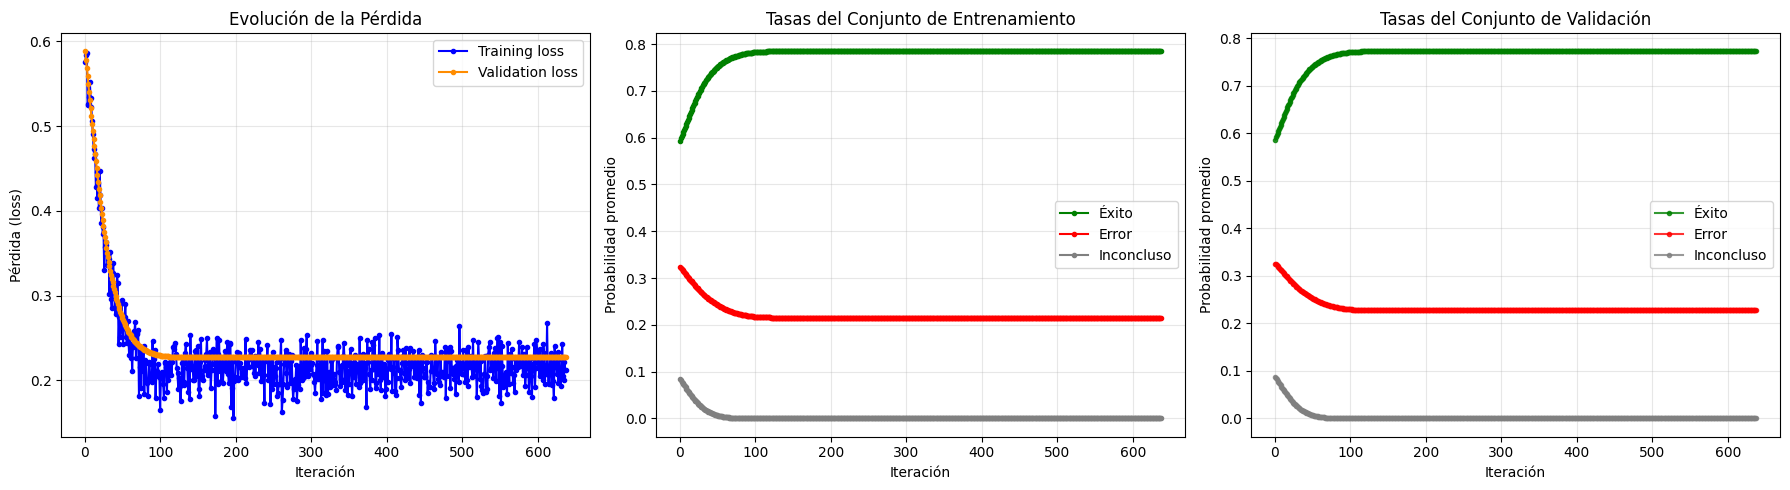

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

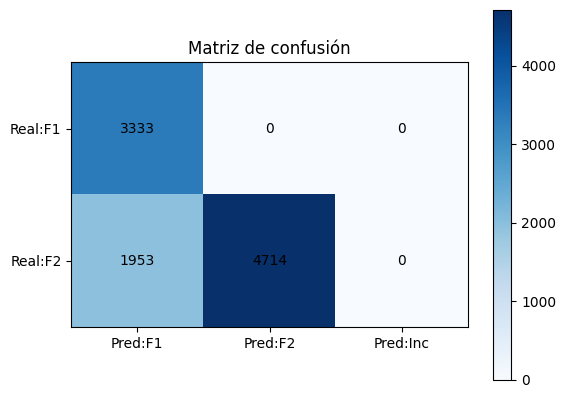

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
